In [396]:
!pip install gower
!pip install xgboost

In [397]:
import pandas as pd
import numpy as np
# visual
import matplotlib.pyplot as plt
import seaborn as sns
# distance
import gower
# sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.metrics import confusion_matrix, rand_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

## Import Data

In [398]:
lst_str_cols = ['move']
dict_dtypes = {x: 'str' for x in lst_str_cols}
data = pd.read_csv('preprocessed_encoded_rocket_league_skillshots.csv', dtype=dict_dtypes)
df = pd.DataFrame(data = data)
df = df.drop(['Unnamed: 0'], axis = 1)

In [399]:
df.head()

,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,goal,Class,move
0,0.005129,0.000000,0.012304,0.498266,0.031512,0.453337,0.300277,0,6,3
1,0.010021,0.010311,0.012290,0.498266,0.024175,0.540209,0.309974,0,6,22
2,0.000000,0.012889,0.012290,0.498266,0.024959,0.540209,0.312201,0,6,18
3,0.031069,0.023200,0.012311,0.498266,0.015971,0.501078,0.342262,0,6,2
4,0.018512,0.046400,0.012387,0.498271,0.016252,0.543875,0.360175,0,6,3


In [400]:
df['move'].dtypes

dtype('O')

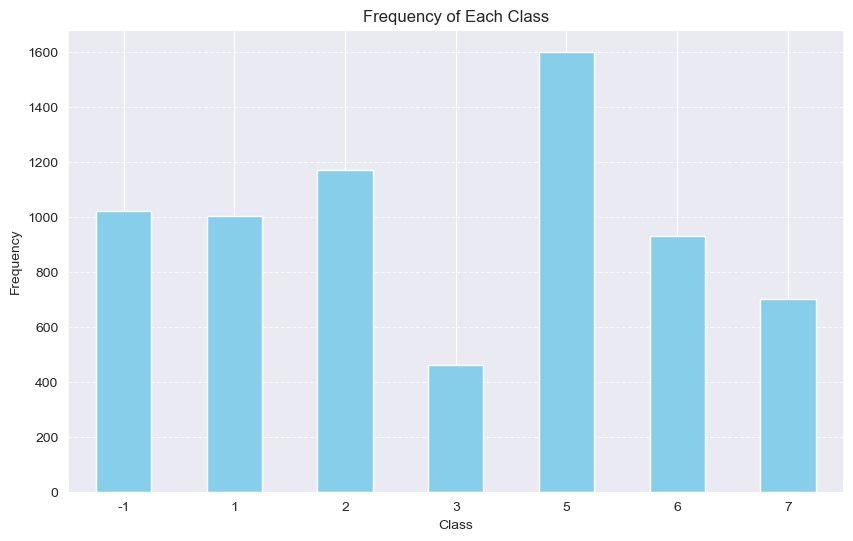

In [401]:
# Plotting the histogram of the frequency of each class including -1
plt.figure(figsize=(10, 6))
df['Class'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the class labels horizontal for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [402]:
df_no_target = df.drop(columns=['Class'])

# Agglomerative Clustering

In [403]:
model = AgglomerativeClustering(n_clusters = 7, affinity = 'precomputed')

In [404]:
target = df[['Class']]
le = LabelEncoder()

labeled_target = target.apply(le.fit_transform)

labels = pd.DataFrame()
labels['target'] = labeled_target.values.reshape(1, -1).tolist()[0]


## Trying three different kinds of linkages for agglomerative clustering

### Single Linkage

In [405]:
model_single_linkage = AgglomerativeClustering(n_clusters = 7, linkage= 'single', metric = 'precomputed')
clusters_single_linkage = model_single_linkage.fit_predict(gower_matrix)

In [406]:
labels['single_linkage_predictions'] = clusters_single_linkage

In [407]:
sri = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_single_linkage)
print(f'Rand Index: {sri}')

Rand Index: 0.16067922925197964


<Axes: ylabel='count'>

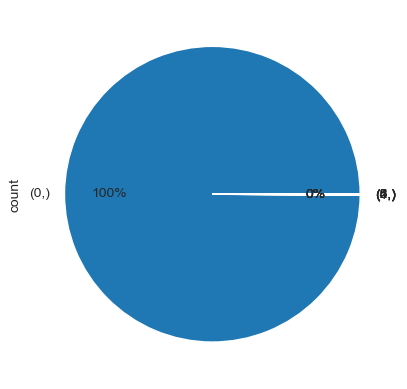

In [408]:
labels[['single_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

This shows that all the data has fallen under one cluster. This is not a good representation of the data

## Average Clustering

In [409]:
model_average_linkage = AgglomerativeClustering(n_clusters = 7, linkage = 'average', metric = 'precomputed')
clusters_average_linkage = model_average_linkage.fit_predict(gower_matrix)

In [410]:
labels['average_linkage_predictions'] = clusters_average_linkage

In [411]:
ari = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_average_linkage)
print(f'Rand Index: {ari}')

Rand Index: 0.3907561765398743


<Axes: ylabel='count'>

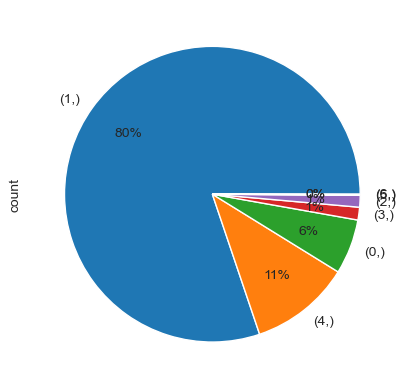

In [412]:
labels[['average_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

The number of classes representing each type of data is diversifying but still the classes are being represented well.

## Complete Linkage

In [413]:
model_complete_linkage = AgglomerativeClustering(n_clusters=7, linkage = 'complete', metric= 'precomputed')
clusters_complete_linkage = model_complete_linkage.fit_predict(gower_matrix)

In [414]:
labels['complete_linkage_predictions'] = clusters_complete_linkage

In [415]:
cri = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_complete_linkage)
print(f'Rand Index: {cri}')

Rand Index: 0.649255933092303


<Axes: ylabel='count'>

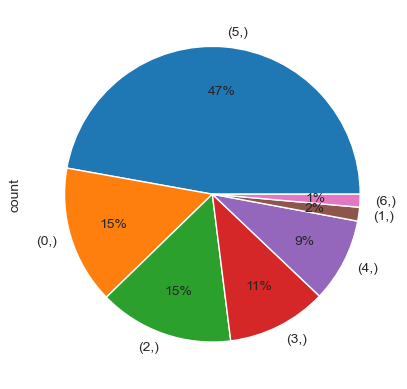

In [416]:
labels[['complete_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

In [417]:
labels.value_counts(["target", "complete_linkage_predictions"])

target  complete_linkage_predictions
4       5                               674
2       5                               655
5       5                               522
1       5                               485
0       5                               400
4       3                               387
6       5                               362
4       2                               223
2       0                               202
1       2                               183
4       0                               179
1       0                               171
0       0                               168
3       5                               153
0       2                               153
2       2                               144
4       4                               126
5       2                               126
        0                               126
3       0                               124
2       4                               115
5       4                              

In [418]:
labels['aligned_clusters'] = labels['complete_linkage_predictions'].apply(lambda x: int(not x))

ValueError: `data` and `annot` must have same shape.

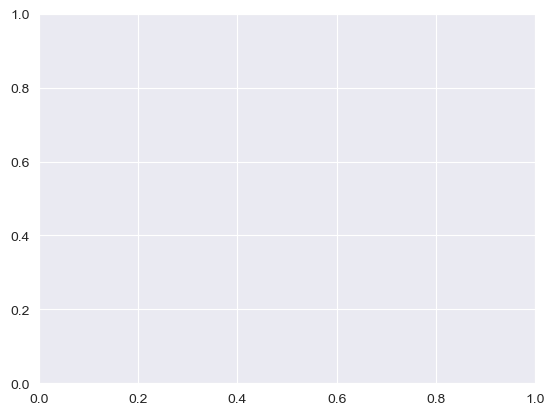

In [419]:
cf_matrix = confusion_matrix(labeled_target.values, labels[["aligned_clusters"]].values)
cf_labels = ['True Neg','False Pos','False Neg','True Pos']
fig, ax = plt.subplots(1, 1)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=cf_labels, fmt='', cmap='Blues')
ax.set_ylabel('Target Labels')
ax.set_xlabel('Predicted Labels')

# Classification

In [421]:
df_target = df[['Class']]
df_no_target.head()

,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,goal,move
0,0.005129,0.000000,0.012304,0.498266,0.031512,0.453337,0.300277,0,3
1,0.010021,0.010311,0.012290,0.498266,0.024175,0.540209,0.309974,0,22
2,0.000000,0.012889,0.012290,0.498266,0.024959,0.540209,0.312201,0,18
3,0.031069,0.023200,0.012311,0.498266,0.015971,0.501078,0.342262,0,2
4,0.018512,0.046400,0.012387,0.498271,0.016252,0.543875,0.360175,0,3


In [422]:
# train test split data 80%-20%

X = df_no_target
y = df['Class']

In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Decision Tree Classifier

In [424]:
# param_grid = {
#     'criterion':["gini","entropy"],
#     'max_depth': [1000],
#     'min_samples_leaf': [1, 2, 3, 4, 5],
#     'min_samples_split': [1, 2, 3,4, 5]
# }

In [425]:
# dtree = DecisionTreeClassifier()
# grid_search = GridSearchCV(dtree, param_grid, cv = 5)
# grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [426]:
# print(grid_search.best_params_)

In [427]:
dtree = DecisionTreeClassifier(max_depth = 1000).fit(X_train, y_train)
# dtree = DecisionTreeClassifier(max_depth = 1000).fit(X_train, y_train)

dtree_prediction = dtree.predict(X_test)

In [428]:
# from sklearn import tree
# classes = ['noise', 'ceiling shot', 'power shot', 'waving dash', 'air dribble', 'front flick', 'musty flick']
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dtree,
#                    feature_names=X.columns.tolist(),
#                    class_names= classes,
#                    filled=True)

In [429]:
cm = confusion_matrix(y_test, dtree_prediction)

In [430]:
cm_graph = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

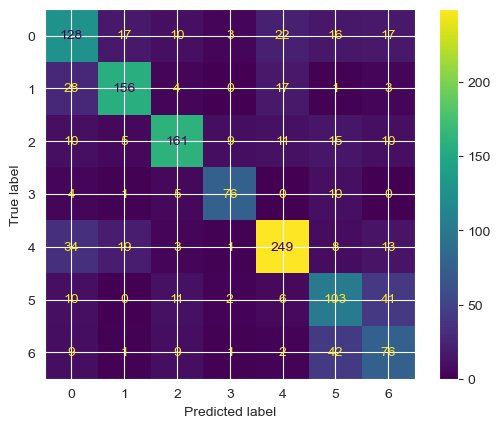

In [431]:
cm_graph.plot()
plt.show()

In [432]:
print(classification_report(y_test, dtree_prediction))

              precision    recall  f1-score   support

          -1       0.57      0.60      0.59       213
           1       0.78      0.75      0.76       209
           2       0.79      0.73      0.76       221
           3       0.83      0.79      0.81        96
           5       0.81      0.76      0.79       327
           6       0.53      0.60      0.56       173
           7       0.47      0.54      0.51       140

    accuracy                           0.69      1379
   macro avg       0.68      0.68      0.68      1379
weighted avg       0.70      0.69      0.69      1379



## Random Forest Classifier

In [433]:
forest = RandomForestClassifier(max_depth = 1000, random_state = 0).fit(X_train, y_train)
forest_prediction = forest.predict(X_test) 

In [434]:
cm = confusion_matrix(y_test, forest_prediction)

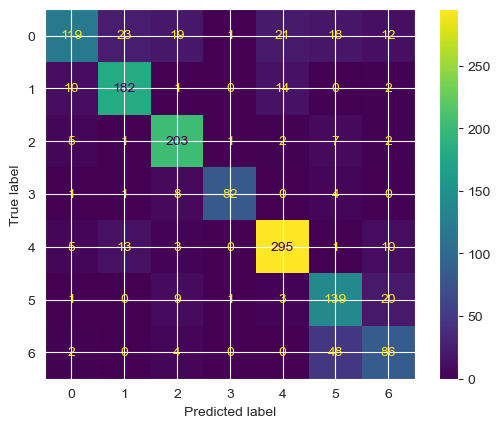

In [435]:
cm_graph = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_graph.plot()
plt.show()

In [436]:
print(classification_report(y_test, forest_prediction))

              precision    recall  f1-score   support

          -1       0.83      0.56      0.67       213
           1       0.83      0.87      0.85       209
           2       0.82      0.92      0.87       221
           3       0.96      0.85      0.91        96
           5       0.88      0.90      0.89       327
           6       0.64      0.80      0.71       173
           7       0.65      0.61      0.63       140

    accuracy                           0.80      1379
   macro avg       0.80      0.79      0.79      1379
weighted avg       0.81      0.80      0.80      1379



## Support Vector Machine (SVM)

### Support Vector Classification (SVC)

In [440]:
param_grid = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [1, 10, 100, 1000],
    'shrinking' : [True, False],
    'gamma' : [0.001, 0.01, 0.1, 1],
    'probability' : [True, False],
    'tol' : [0.0001, 0.0005, 0.001, 0.005],
    'cache_size' : [-1, -2, -3, -4, -5, -6, -7, -8],
    'class_weight' : ['balanced', None],
    'verbose' : [True, False],
    'max_iter' : [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000],
    'decision_function_shape' : ['ovr', 'ovo'],
    'break_ties' : [True, False],
    'random_state' : [0, 1, 2, 3, 4, 5, 6, 7]
}

In [441]:
svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
df_svc_score = pd.DataFrame(grid_search.cv_results_)
df_svc_score.head()

In [ ]:

svc.fit(X_train, y_train)
svc_predictions = svc.predict(X_test)

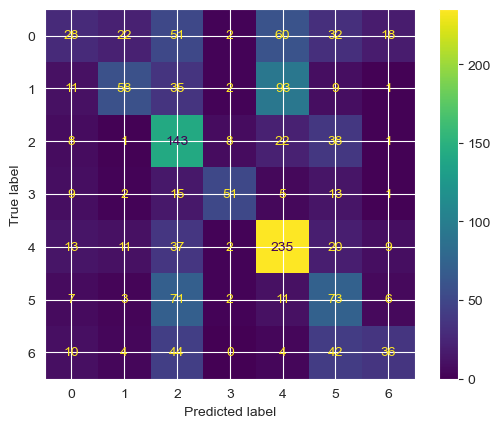

In [438]:
cm = confusion_matrix(y_test, svc_predictions)
cm_graph = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_graph.plot()
plt.show()

In [439]:
print(classification_report(y_test, svc_predictions))

              precision    recall  f1-score   support

          -1       0.33      0.13      0.19       213
           1       0.57      0.28      0.37       209
           2       0.36      0.65      0.46       221
           3       0.76      0.53      0.63        96
           5       0.55      0.72      0.62       327
           6       0.32      0.42      0.36       173
           7       0.50      0.26      0.34       140

    accuracy                           0.45      1379
   macro avg       0.48      0.43      0.43      1379
weighted avg       0.47      0.45      0.43      1379



### Nu-Support Vector Classification (NuSVC)

### Linear Support Vector Classification